# In which I struggle to find an MCMC pun that involves the phrase "mark off", and learn  some Monte Carlo in the meantime.

Markov Chain Monte Carlo (MCMC) is a technique for generating a sample from a distribution, and it works even if all you have is a non-normalized representation of the distribution. Why does a data scientist care about this? Well, in a Bayesian analysis a non-normalized form of the posterior distribution is super easy to come by, being just the product of likelihood and prior - so **MCMC can be used to sample from (essentially simulate) a Bayesian posterior**. In python one of the most widely used packages for doing exactly this is called [`PyMC`](https://pymc-devs.github.io/pymc/#), and this post is me having a go at understanding it and typing up a reference for myself. Note that I'm mostly following [this](http://www.map.ox.ac.uk/media/PDF/Patil_et_al_2010.pdf) excellent technical article and the coding example in it, but I'm (hopefully) going to extract out only the most basic and important features.

First a quick refresher on how MCMC achieves this magic. 

# A Reminder of What MCMC is *Actually* Doing
Since PyMC takes over so much of the operation of the analysis once you've fully specified your model and priors, it would be really easy to forget what exactly MCMC does and how it works. Here is a reminder:

- A Markov Chain is a sequence of RVs $\{X\}$ each of which will have an observed value from the state space of possible values, $\{x\}$.
- A Markov Process is a sequence of such RVs where the distribution of the initial RV's value is specified ($\Pi_0$) as well as a *Transition Rule* ($\mathbf{P}$) which gives the probability to transition from one state to another, $\mathbf{P}(i,j) = P(X_{n+1}=x_j | X_n=x_i)$, for all pairs of states.
- Notice $P$ does not give a crap what happened in the chain leading up to the current state, this "memorylessness" is an important element of the definition of a Markov Process. 
- Time-reversible Markov Processes are those which satisfy $\mu_i\mathbf{P}(i,j)=\mu_j\mathbf{P}(j,i)$ for some distribution $\mu$. Such processes have the guarantee that the long-run fractions of state values in the sequence approaches $\mu$. 
- Thus if we want a sample from a distribution $\mu$ we could just find a $\mathbf{P}$ with which it satisfies time-reversibility and then simulate a long Markov Chain.
- The **Metropolis-Hastings** Method is an algorithm for constructing such a $\mathbf{P}$ given only a non-normalized form of the $\mu$ of interest.
- So given a non-normalized posterior from a Bayesian analysis, we can run an MCMC and get a simulated sample from it, which allows us to estimate various things about this posterior distribution. 

Now that all of that is 100% super clear and obvious, lets get our environment set up:

In [55]:
from matplotlib import pyplot as plt
import pymc 
import numpy as np
log = np.log
pi = np.pi

# PyMC: Markov Chain Monte Carlo in Python
`PyMC` is a python package that helps users define stochastic models and then construct Bayesian posterior samples via MCMC. There are two main object types which are building blocks for defining models in `PyMC`: `Stochastic` and `Deterministic` variables. All `PyMC` models are linked groups of such variable objects, meaning linked together by being passed as inputs to one another. As discussed below, a potential point of confusion is the `Deterministic` class is actually used to instantiate random variables (which are definitively non-deterministic).

## `Stochastic` and `Deterministic` Subclasses (Variables)
All `Stochastic` and `Deterministic` variables in PyMC have parents (variables that are their inputs) and children (variables which take them as an input). **Variables represented by the `Deterministic` subclass are those whose specific value is completely determined by the value of their parents, while variables represented by the `Stochastic` subclass have a probability distribution for their value given the values of the parents.** This is confusing terminology because often `Deterministic`-implemented variables are RVs since their parents are RVs. 

To prepare for implementing your system in PyMC you should write down your model in the following form:
- distribution of the data given all the relevant quantities
- deterministic expressions for any deterministic quantities
- distributions for any uncertain quantities

## Setting Up a PyMC Model
[Here is an excellent example](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3097064/pdf/ukmss-31574.pdf): a data set of the number of coal mine disasters per year over many years, defined as an numpy array below:

In [4]:
disasters_array =   np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

The disasters are going to be modeled as Poisson events with the goal of identifying which year a change in the rate parameter occurs (due to regulation being passed). Lets define some quantities for this system so that we can set up a model:
- $D(t)$ is the data as a function of year
- $r(t)$ is the rate parameter which also dependson the year since there is a point at which it switches
- $s$ is the year of the switch
- $e$ is the earlier value of $s$ while $l$ is the later value of $s$
- $t_l$ an $t_h$ are the first and last years of the data set. 
 
Here would be a good way to write out this model before even touching your keyboard:

$\begin{align*}
(D(t) | e,s,l) \sim Poisson(r(t))\\
r(t) = 
\begin{cases} 
      e & t\leq s \\
      l & t\geq s 
\end{cases}\\
s \sim \mathrm{DiscreteUniform}(t_l, t_h)\\
e \sim \mathrm{Exponential}(r_e)\\
l \sim \mathrm{Exponential}(r_l)\\
\end{align*}$

If you can't write down something like the above on pencil and paper then you aren't ready to code and you'll want to spend some more time mathematically representing your system and specifying your model. Assuming you're good with all that, then you need to start out by implementing each variable as an appropriate object in `PyMC`. In this case the only thing we would implement as `Deterministic` would be $r(t)$, whose parents $s$, $l$ and $e$ fully determine it. The `Stochastic` implementation of $s$, $e$, and $l$ is our Bayesian prior ($r_e$ and $r_l$ are just specific constants we need to choose for these priors), while the stochastic implementation of $D(t)$ is our likelihood.

**PyMC defines subclasses of `Stochastic` for lots of common distributions, so that we can quickly and easily instantiate the RVs in our model.** The functions that construct these stochastic objects take the "handle" of the stochastic quantity as their first input. Let's try it out by specifying our priors:

In [7]:
s = pymc.DiscreteUniform("s", lower=0, upper=110)  # Returns an object of the stochastic subclass discrete uniform
e = pymc.Exponential("e", beta=1)  # Choose r_e to be 1 gives a reasonable prior
l = pymc.Exponential("l", beta=1)  # Choose r_l to be 1 gives a reasonable prior

In addition, for each common distribution PyMC defines a function suffixed by `_like()` which returns the log-likelihood of a value under that distribution, e.g. `logprob = discrete_uniform_like(x=0.5, lower=0, upper=110)`. 

Remember that we have one variable that is deterministic - $r$. **To instantiate RVs that are represented by `Determinisic` class we need to use a decorator defined in the module `@deterministic`**. The decorator function should return the value of the variable for the given input (parent) values:

In [10]:
@pymc.deterministic(plot=False)
def r(s=s, e=e, l=l):
    """Concatenate the two Poisson mean values"""
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

Notice that `s` and `e` are actually `Stochastic` objects, but within the definition of `r` we are able to treat them like numbers (as slice indexes). This is because for objects used as parents of a variable, PyMC will replace the objects with their present values whenever the variables value or log-probability needs to be computed.

The data `D` is a final stochastic random vector, but it is special in that **we have a fixed set of observed values for it - this is indicated to PyMC by the `observed` keyword:**

In [11]:
D = pymc.Poisson("D", mu=r, value=disasters_array, observed=True)

As an aside, you can also create `Stochastic` objects by decorating functions (`@stochastic`) that compute their log-probabilities (whereas for `@deterministic` decorates functions which compute the variable value).

All the above variables constitute our model and the nature of the linkages amongst them can be examined by looking at the `children` and `parents` attribute of each variable. For instance:

In [12]:
D.parents

{'mu': <pymc.PyMCObjects.Deterministic 'r' at 0x000001F519677EB8>}

This is a dictionary - it tells us that the stochastic variable D has one parent, the Deterministic object called "r", and htis object is labeled as "mu" in the internal workings of `D`. We expect that `r` should have `D` as it's child:

In [13]:
r.children

{<pymc.distributions.new_dist_class.<locals>.new_class 'D' at 0x000001F5196779B0>}

A model (collection of linked varibles) can be represented by a directed acyclic graph where e.g. unobserved stochastic variables are open ellipses, observed stochastic variables are filled ellipse, and deterministic variables are triangles. Arrows point from parent to child and display the label that the child assigns to the parent. You can create the model from all of our defined variables, and then print the graph for your model, but it requires an install so I've commented it out below:

In [20]:
minemodel = pymc.Model([e, l, s, r, D])
#pymc.graph.graph(minemodel)

**All PyMC variables have an attribute `value` that stores the current value of that variable** (randomly initialized if `not observed`) and furthermore stochastic objects can evaluate their pmf or pdf at their current value given the current values of their parents. The **`logp` attribute returns this log likelihood** (for random vectors like `D` it returns the sum of the logarithms of the joint probability or density of all elements of the value). 

For example, since we specified our prior on $s$ to be discrete uniform on 1 to 110, we expect it to be randomly initialzed somewhere in that range, and the log probability for that value should be $\log_{10}(\frac{1}{110})$:

In [29]:
print(s.parents)
print(s.value)
print(np.exp(s.logp))
print(1/110)  # for good measure

{'upper': 110, 'lower': 0}
41
0.00900900900901
0.00909090909090909


## Fitting PyMC Models
PyMC provides several objects that fit probability models (linked collections of variables) - the primary such object being `MCMC` (fits with Markov chain Monte Carlo algorithm). **"Fitting" a Bayesian model means characterizing the posterior distribution somehow**. Here are trying to represent the posterior $p(s, e, l|D)$ by a set of joint samples from
it - the MCMC sampler randomly updates the values of s, e and l according to the Metropolis-Hastings algorithm. You can create an MCMC fitting object for your model by:

In [22]:
sampler = pymc.MCMC(minemodel)

The **fitting object `M` has attributes which correspond to the variables we put into it e.g. `M.D`, `M.s` etc. and methods that let us conduct the fit.** For example `M.isample(number of iterations, burn-in length, thinning interval)` will start a fitting routine that can be interrupted at any time (the "i" means "interactive"). The burn-in should be some number of algorithm steps beyond which you reasonably expect convergence. The thinning parameter retains only every `kth` draw and mitigates auto-correlation. This is useful when you compute statistics from the posterior and want to assume like your MCMC sample is a set of *iid* draws from the posterior. For instance, if you use the MCMC sample mean as an estimator for the true posterior mean then you might want to say something about it's distribution - much easier if the sample is *iid*. **If you don't have a good idea for `burn` or `thin` then keep everything and inspect it all!** 

In [23]:
# Will create a sample of 10000 draws from the posterior by Met-Hast algo
sampler.sample(iter=10000, burn=1000, thin=10)  

 [-----------------100%-----------------] 10000 of 10000 complete in 1.7 sec

## Inspecting MCMC Results
The result of calling the `sample()` method is that a new attribute is created in `M`, the fitting object, which stores the resulting samples - these can be accessed by the `trace` method of the fitting object:

In [24]:
s_tr = sampler.trace("s")
type(sampler.trace("s"))

pymc.database.ram.Trace

In [25]:
sampler.trace("s")[1:10]  # Just look at the first few values

array([37, 37, 37, 37, 37, 37, 37, 37, 37])

(array([   2.,    3.,    0.,    4.,    0.,    5.,   71.,  186.,   34.,
           0.,  131.,  130.,  188.,   77.,    0.,   20.,   14.,    3.,
          30.,    2.]),
 array([ 31. ,  31.8,  32.6,  33.4,  34.2,  35. ,  35.8,  36.6,  37.4,
         38.2,  39. ,  39.8,  40.6,  41.4,  42.2,  43. ,  43.8,  44.6,
         45.4,  46.2,  47. ]),
 <a list of 20 Patch objects>)

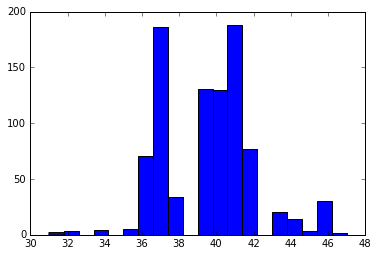

In [27]:
%matplotlib inline
plt.hist(s_tr[:],bins=20)

The Matplot submodule of PyMC defines a `plot(model)` function which defaults to a very useful visualization of the trace of a model, plotting the `Stochastic` components in terms of time series of Metropolis-Hastings and a histogram of values.

Plotting l
Plotting e
Plotting s


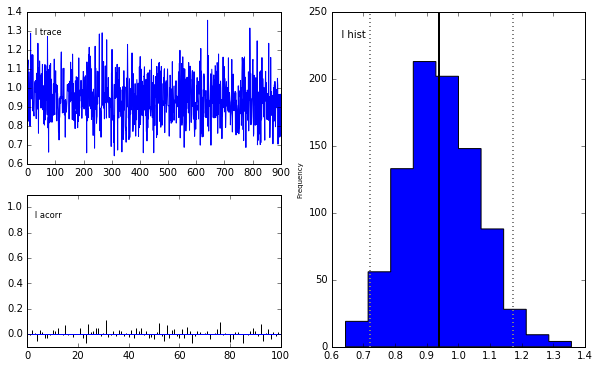

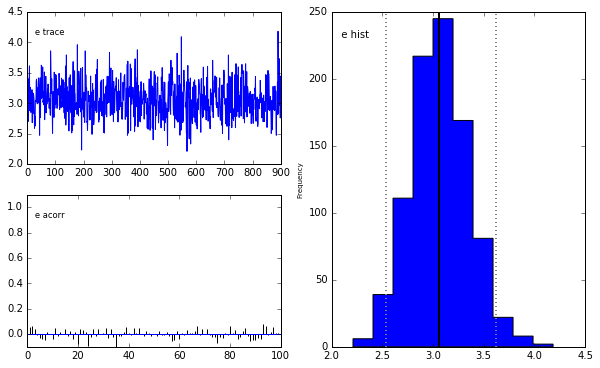

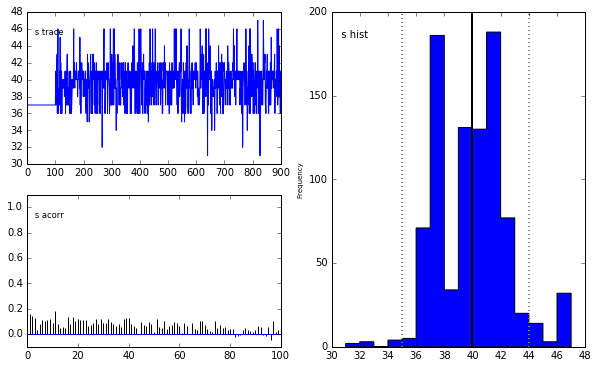

In [28]:
pymc.Matplot.plot(sampler)

# Calculating Probabilities from MCMC Results
Trace objects have a nice little method called `.stats()` which returns some good descriptive statistics of the sample:

In [30]:
s_tr.stats()

{'95% HPD interval': array([ 35.,  44.]),
 'mc error': 0.1183359415466341,
 'mean': 39.483333333333334,
 'n': 900,
 'quantiles': {2.5: 36.0, 25: 37.0, 50: 40.0, 75: 41.0, 97.5: 46.0},
 'standard deviation': 2.4972762940629716}

Alternatively the method `stats()` for a *Fitting Object* returns a dictionary with keys for each variable and entries with nice summary values.

In [31]:
sampler.stats()["e"]

{'95% HPD interval': array([ 2.53940542,  3.62556813]),
 'mc error': 0.0095947658494946655,
 'mean': 3.0697409128224913,
 'n': 900,
 'quantiles': {2.5: 2.5394054181768095,
  25: 2.8756569678436681,
  50: 3.0595943198980571,
  75: 3.2518509997277714,
  97.5: 3.6255681335759564},
 'standard deviation': 0.28231161815605127}

In [32]:
sampler.stats()["e"]["mean"] # Same as np.mean(M.trace("e")[:])

3.0697409128224913

## Missing Data in PyMC
A naive approach to data sets where some entries are missing the value of one or more variables is just to exclude those entries from analysis, but this is wasteful of information. In the Bayesian approach the missing values can be considered like future observations, and we can calculate a probability distribution for their values by using the posterior predictive distribution:

$p(\hat{y}|y) = \int{p(\hat{y}|\theta)f(\theta|y)}d\theta,$

where $\hat{y}$ are the missing values and $y$ are the rest of the data.

You can execute this by generating a numpy masked array from the RV containing missing values, and passing it into the PyMC `Impute` function which replaces the missing values with Stochastic variables of the desired type. 

In [ ]:
x = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, None, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, None, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [ ]:
masked_data = np.ma.masked_equal(x, value=None)
# D = pymc.Impute("D", pymc.Poisson, masked_data, mu=r)  # compare to D = pymc.Poisson("D", mu=r, value=disasters_array)

Now each element in D is a Poisson `Stochastic`, with actual observations having `observed=True`, while missing observations have `False` and will be estimated by the MCMC algorithm, just like unknown model parameters.

# Summary
And THAT is how you use python to do Bayesian inference. I didn't have anything more insightful to put in a summary.
